# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. 

Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак.

## Подготовка BERT

In [2]:
!pip install torch
!pip install transformers

  Using cached torch-1.13.1-cp39-cp39-win_amd64.whl (162.5 MB)
  Using cached transformers-4.26.1-py3-none-any.whl (6.3 MB)
  Using cached huggingface_hub-0.13.1-py3-none-any.whl (199 kB)
  Using cached tokenizers-0.13.2-cp39-cp39-win_amd64.whl (3.3 MB)


In [16]:
!pip install catboost
!pip install lightgbm

  Using cached catboost-1.1.1-cp39-none-win_amd64.whl (74.0 MB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
     ---------------------------------------- 1.0/1.0 MB 5.0 MB/s eta 0:00:00


In [3]:
# импортируем библиотеки
import warnings

import numpy as np
import pandas as pd

import torch
import transformers

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import notebook

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

warnings.filterwarnings('ignore')

In [4]:
# загрузим датасет
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('datasets/toxic_comments.csv', index_col=0)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Проценты классов:
0    89.84
1    10.16
Name: toxic, dtype: float64


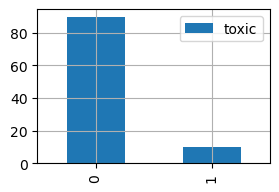

In [6]:
class_frequency = round((data['toxic'].value_counts() / data.shape[0]) * 100, 2)
print('Проценты классов:')
print(class_frequency)
class_frequency.plot(kind='bar', legend=True, figsize=(3,2), grid=True);

In [19]:
#data_sample = data.sample(10000)
data_sample, _ = train_test_split(data,
                                  train_size=4000/data.shape[0], 
                                  random_state=12345,
                                  stratify=data['toxic'])


In [20]:
print(f'Процент от исходного датасета: {(data_sample.shape[0] / data.shape[0]):.2%},\nРазмер выборки: {data_sample.shape}')

Процент от исходного датасета: 2.51%,
Размер выборки: (4000, 2)


Проценты классов:
0    89.85
1    10.15
Name: toxic, dtype: float64


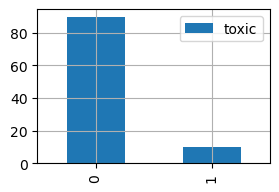

In [21]:
class_frequency = round((data_sample['toxic'].value_counts() / data_sample.shape[0]) * 100, 2)
print('Проценты классов:')
print(class_frequency)
class_frequency.plot(kind='bar', legend=True, figsize=(3,2), grid=True);

Наблюдения:
- Есть столбец `Unnamed: 0` - видимо, бывшие индексы. Его можно просто удалить.
- Столбец `toxic` - целевой признак, содержит два класса: `0` - не токсичный комментарий, `1` - токсичный. Заметен сильный дисбаланс классов, токсичных всего 10% всего датасета.
- Столбец `data['text']` - содержит фразы на английском. Следовательно нужен BERT для английского языка. 
    - Так как BERT очень тяжелый, возьмем семпл 10 тысяч объектов. Проверили, сохраняется ли на этой выборке дисбаланс. 9,96% - примерно так же, как и в всем датасете.


In [22]:
from transformers import AutoTokenizer, AutoModel

#tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/bert-base-cased-conversational")
#model = AutoModel.from_pretrained("DeepPavlov/bert-base-cased-conversational")

model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
tokenized = data_sample['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [24]:
tokenized.shape

(4000,)

In [25]:
padded.shape

(4000, 512)

Специально пришлось обрезать длину векторов
truncation=True, max_length=512

In [26]:
%%time
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/40 [00:00<?, ?it/s]

Wall time: 1h 10min 44s


За 3,5 часа у меня посчиталось 6,3% всего датасета :)))

UPD: toxic-bert 1ч10мин на 2.51% датасета.

In [27]:
bert_features = np.concatenate(embeddings)

In [28]:
bert_features.shape

(4000, 768)

In [29]:
# сохраню на всякий случай фичи
df_bert_features = pd.DataFrame(bert_features, index=data_sample.index)
df_bert_features['toxic'] = data_sample['toxic']
df_bert_features.to_csv("datasets/toxic_bert_features_target.csv",index=False)
#df_bert_features.to_csv("datasets/bert_features_target.csv",index=False)

In [30]:
df_bert_features.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,toxic
133007,-0.409640,-0.682354,0.694877,-0.387380,1.116177,0.367554,0.638707,0.035917,-0.429374,-0.693715,...,-1.092966,0.370968,-0.651163,-0.013004,0.653972,-0.355653,-0.611036,0.687749,0.381993,0
3710,-0.858708,-1.081910,0.246214,-0.550063,1.226489,0.493677,-0.063121,-0.145448,-0.379268,-0.509379,...,-1.157018,0.249814,-0.680220,0.068209,0.829675,-0.421107,-0.830782,0.453771,-0.038509,0
8981,-0.673145,-0.880663,0.753622,-0.465708,1.274365,0.298940,0.004354,0.297773,-0.453670,-0.673237,...,-0.946159,0.303214,-0.681259,0.174515,0.657640,-0.611828,-0.646030,0.652186,0.425806,0
81809,-0.635174,-0.989515,0.437669,-0.366011,1.064908,0.238560,-0.169302,0.040857,-0.451379,-0.645360,...,-1.245401,0.122063,-0.707842,0.221734,0.997048,-0.613303,-0.706120,0.391476,0.117196,0
58025,-0.568447,-0.787825,0.586156,-0.601193,1.032078,0.429114,0.234472,-0.090180,-0.343484,-0.768675,...,-1.131095,0.603504,-0.550489,0.122606,0.531818,-0.572755,-0.675945,0.646105,0.237480,0


In [31]:
# если при перезапуске ядра все потерялось
#df_bert_features = pd.read_csv('datasets/bert_features_target.csv')
df_bert_features = pd.read_csv('datasets/toxic_bert_features_target.csv')

In [32]:
bert_features = df_bert_features.drop('toxic', axis=1)
bert_target = df_bert_features['toxic']
bert_features.shape

(4000, 768)

## Обучение BERT

In [34]:
bert_features_train, bert_features_test, bert_target_train, bert_target_test = train_test_split(bert_features, 
                                                                                                bert_target, 
                                                                                                test_size=0.25,
                                                                                                random_state=12345)

print("Размер матрицы обучающей выборки:", bert_features_train.shape)
print("Размер матрицы тестовой выборки:", bert_features_test.shape)

Размер матрицы обучающей выборки: (3000, 768)
Размер матрицы тестовой выборки: (1000, 768)


В случае использования эмбедингов от Берта, никакой утечки данных нет. Поэтому проще сделать преобразование (векторизацию) на всём датасете, а потом разделить на выборки - меньше кода.

### Logistic Regression

In [35]:
# Logistic Regression без взвешивания
bert_model = LogisticRegression(random_state=12345, max_iter=1000) #, class_weight='balanced'
bert_model.fit(bert_features_train, bert_target_train) 

print(f'F1 на обучающей выборке:', cross_val_score(bert_model, 
                                                    bert_features_train, 
                                                    bert_target_train, 
                                                    cv = 4, 
                                                    n_jobs = -1, 
                                                    scoring = 'f1').mean())


F1 на обучающей выборке: 0.9392318546719358


In [38]:
%%time
# Logistic Regression. Подбор параметров
print('\tLogistic Regression BERT (GridSearchCV)')
bert_model_logreg = LogisticRegression(random_state=12345)

parameters = {'max_iter': [100, 500, 1000, 2000],
              'class_weight': [None, 'balanced'],
              'C': np.arange(0.1, 2.0, 0.2)
              #'solver': ['lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga']
             }

bert_grid_logreg = GridSearchCV(bert_model_logreg, parameters, cv=3, verbose=3, n_jobs=-1, scoring = 'f1')
bert_grid_logreg.fit(bert_features_train, bert_target_train)

print(f'F1 на обучающей выборке: {abs(bert_grid_logreg.best_score_)}')

print('Гиперараметры:', bert_grid_logreg.best_params_)

	Logistic Regression BERT (GridSearchCV)
Fitting 4 folds for each of 80 candidates, totalling 320 fits
F1 на обучающей выборке: 0.9392318546719358
Гиперараметры: {'C': 0.9000000000000001, 'class_weight': None, 'max_iter': 100}
Wall time: 1min 29s


__Logistic Regression__

Как было до этого с `bert-base-cased-conversational`:
- `{'C': 0.3, 'class_weight': None, 'max_iter': 100}`
- `F1` на обучающей выборке: `0.66253`
- Время: прим. 5 мин

Как стало с `toxic-bert`:
- `{'C': 0.9, 'class_weight': None, 'max_iter': 100}`
- `F1` на обучающей выборке: `0.93923`
- Время: Wall time: 1min 29s

Стало быстрее и гораздо точнее. Метрика F1 улучшилась. 

Вывод: правильный подбор предобученной модели Bert существенно влияет на качество.

### LightGBM Classifier

In [41]:
%%time
# LightGBM. Подбор параметров
print('\tLight GBM Classifier BERT (GridSearchCV)')
bert_model_lgbm = LGBMClassifier(random_state=12345)

parameters = {'max_depth': [-1, 2, 3, 5], 
              'class_weight': [None, 'balanced'],
              'n_estimators': [50, 100, 150, 300], #50
              #'learning_rate': [0.1, 0.01]
              'num_leaves':[10, 30, 50]
             }

bert_grid_lgbm = GridSearchCV(bert_model_lgbm, parameters, cv=3, verbose=3, n_jobs=-1, scoring = 'f1')
bert_grid_lgbm.fit(bert_features_train, bert_target_train)

print(f'F1 на обучающей выборке: {abs(bert_grid_lgbm.best_score_)}')
print('Гиперараметры:', bert_grid_lgbm.best_params_)

	Light GBM Classifier BERT (GridSearchCV)
Fitting 3 folds for each of 96 candidates, totalling 288 fits
F1 на обучающей выборке: 0.9356526405222914
Гиперараметры: {'class_weight': 'balanced', 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10}
Wall time: 4min 32s


__LightGBM__

Как было до этого с `bert-base-cased-conversational`:
- `{'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 100}`
- `F1` на обучающей выборке: `0.63551`
- Время: Wall time: 2min 44s

Как стало с `toxic-bert`:
- `{'class_weight': None, 'max_depth': 2, 'n_estimators': 100}`
- `F1` на обучающей выборке: `0.93111`
- Время: Wall time:  1min 25s

Снова стало быстрее и точнее, но не настолько точно, как у ЛогРег.

Подберем побольше параметров.
- `'class_weight': 'balanced', 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10`
- `F1` на обучающей выборке: `0.93565`
- Wall time: 4min 32s

Стало еще лучше, но до ЛогРега все равно не хватает 4 тысячных доли.

### Random Forest

In [45]:
%%time
# RandomForest Classifier. Подбор параметров
print('\tRandomForest Classifier BERT (GridSearchCV)')
bert_model_forest = RandomForestClassifier(random_state=12345)

parameters = {'max_depth': [None, 3, 5, 50], 
              'class_weight': [None, 'balanced', 'balanced_subsample'],
              'n_estimators': [50, 60, 100, 300],
              'min_samples_split': [2, 3, 5]
              #'min_samples_leaf': [1, 3, 5]
             }

bert_grid_forest = GridSearchCV(bert_model_forest, parameters, cv=3, verbose=3, n_jobs=-1, scoring = 'f1')
bert_grid_forest.fit(bert_features_train, bert_target_train)

print(f'F1 на обучающей выборке: {abs(bert_grid_forest.best_score_)}')
print('Гиперараметры:', bert_grid_forest.best_params_)

	RandomForest Classifier BERT (GridSearchCV)
Fitting 3 folds for each of 144 candidates, totalling 432 fits
F1 на обучающей выборке: 0.9378437505650075
Гиперараметры: {'class_weight': None, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 60}
Wall time: 2min 6s


__RandomForest__

Как было до этого с `bert-base-cased-conversational`:
- `'class_weight': None, 'max_depth': None, 'n_estimators': 300	`
- `F1` на обучающей выборке: `0.3822`
- Время: Wall time: 2min 45s

Как стало с `toxic-bert`:
- `'class_weight': None, 'max_depth': None, 'n_estimators': 50`
- `F1` на обучающей выборке: `0.93622`
- Время: Wall time: 42s

Опять быстрее и точнее, лучше, чем LightGBM, но все еще чуть хуже ЛогРег.

Подберем побольше параметров.

- `'class_weight': None, 'max_depth': None, 'n_estimators': 60`
- `F1` на обучающей выборке: `0.93767`
- Время: Wall time: 50.6 s

№2

- `'class_weight': None, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 60`
- `F1` на обучающей выборке: `0.93784`
- Время: Wall time: 2min 6s

## Выводы



Сводка по моделям (__при использовании BERT-base-cased-conversational__, выборка 10000 объектов) на обучающей выборке:

| Модель   | Гиперпараметры                                                 | Точность результата (F1 score) | 
|:----------------------------:|:--------------------------------------------------------------:|:------------------------------:|
| Логистическая регрессия      | `'class_weight': None, 'C': 0.3, 'max_iter': 100`              | 0.6625              | 
| Light GBM                    | `'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 100` | 0.6355           |
| Random Forest                | `'class_weight': None, 'max_depth': None, 'n_estimators': 300`    | 0.3822           |


Сводка по моделям (__`при использовании toxic-BERT`__, выборка 4000 объектов) на обучающей выборке, внимание на точность:

| Модель                       | Гиперпараметры                                                 | Точность результата (F1 score) | 
|:----------------------------:|:--------------------------------------------------------------:|:------------------------------:|
| Логистическая регрессия      | `'C': 0.9, 'class_weight': None, 'max_iter': 100`              | 0.93923             | 
| Light GBM                    | `'class_weight': 'balanced', 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 10` | 0.93565         |
| Random Forest                | `'class_weight': None, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 60`    | 0.93784          |

Лучше всего показала себя __логистическая регрессия__, как по точности, так и по времени подбора параметров. 

Возможно, если лучше подбирать параметры для леса и градиентного бустинга, то они тоже покажут лучше результаты. 

_Также, важна модель BERT - правильно подобранная модель под задачу сильно влияет на точность предсказаний._

In [47]:
# тестовая выборка
bert_predictions_test = bert_grid_logreg.predict(bert_features_test)
print(f'F1 на тестовой выборке: ', f1_score(bert_target_test, bert_predictions_test))


F1 на тестовой выборке:  0.9206349206349206


На тестовой выборке логистическая регрессия показала себя так же хорошо: результат по ___f1 метрике равен `0.92`___.

А при использовании BERT-base-cased-conversational, на тестовой выборке метрика f1 была равна 0.7011. Разница на лицо.



- _Почему была выбрана метрика f1?_

    Предполагаю, что метрика F1 выбрана, потому что есть дисбаланс классов, и она показывает общее среднее между точностью (precision) и полнотой (recall). То есть мы стремимся сразу и к более точному предсказанию токсического комментария, и одновременно нам нужно угадать их как можно больше. То есть стремимся к балансу. Можно сказать, что в этой задаче accuracy бессмысленна, так как сильный дисбаланс. Но почему не AUC-ROC, тут сложно. Можно предположить, что в F1 метрике важны точность и полнота угадывания одного класса с учетом дисбаланса, а в AUC-ROC важны полнота угадывания положительного класса и полнота угадывания отрицательного класса бинарной классификации - и их гармония.
    
    
- _Что если бы нам было нужно найти как можно больше токсичных комментариев, в этом случаи на какую метрику мы бы ориентировались?_

    Полнота (recall) - так как именно она увеличивается, когда доля правильно предсказанных объекто класса "1" действительно подходит к доле всех объектов класса "1" на датасете. То есть как можно больше угадать токсичных комментариев из всех.
    
    
- _Каким образом мы можем изменить функцию ошибки в модели, чтобы она максимизировала интересующую нас метрику (accuracy, f1, precision, roc-auc и т.п.)?_

    Мы никак не можем изменить функцию ошибки, чтобы в процессе обучения, двигаясь по антиградиенту, минимизировались какие то конкретные метрики качества (precision или recall или roc-auc - нет у них производной).